In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

# New Section

In [2]:
#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

12G


In [3]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 19.8 MB/s eta 0:00:00


In [4]:
import keras
import tensorflow as tf
#from keras.layers import merge
from keras.layers import Input , Add 
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization

from keras.layers import Dropout,AveragePooling2D
from keras.models import Model
#from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import math
from google.colab.patches import cv2_imshow

from skimage import feature
from keras.layers import Concatenate, Lambda
init_notebook_mode(connected=True)
%matplotlib inline

In [5]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.90
windowSize = 25

In [6]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/data/')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [7]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [8]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [9]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [10]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [11]:
# from scipy.fftpack import dct,idct
# def dctn(X, norm='ortho'):
#   for i in range (X.ndim):
#     X=dct(X, axis=i, norm=norm)
#   return X

In [12]:
X, y = loadData(dataset)
X.shape, y.shape

((145, 145, 200), (145, 145))

In [13]:
K = 30 if dataset == 'IP' else 10
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [14]:
def slicscr(curlayer):
  k = 100
  np_array = curlayer
  #print(np_array.shape)
  n = len(np_array) * len(np_array[0])
  #print(n)
  row = len(np_array)
  column = len(np_array[0])
  s = np.sqrt(n/k)
  #print(s,row,column)
  class cluster_centre:
    def __init__(self, l_value, x_pos, y_pos):
      self.l_value = l_value
      self.x_pos = x_pos
      self.y_pos = y_pos

  center = []
  # for i in range(0,k):
  #     center.append(cluster_centre(0,0,0))
  i=round(s/2)
  j=round(s/2)
  s=round(s)
  while(i<row) :
    while(j<column) : 
      center.append(cluster_centre(np_array[i][j],i,j))
      j+=s
    i+=s
    j=round(s/2)
  #print(len(center))
  #print(s)
  for i in range(len(center)) :
  #print(i)
  #print(center[i].l_value)
    minslope=300
    shiftedx=center[i].x_pos
    shiftedy=center[i].y_pos
    grad = np_array[center[i].x_pos-1][center[i].y_pos]-np_array[center[i].x_pos][center[i].y_pos]
    if(grad<minslope) :
      shiftedx=center[i].x_pos-1
      shiftedy=center[i].y_pos
    grad = (np_array[center[i].x_pos-1][center[i].y_pos-1]-np_array[center[i].x_pos][center[i].y_pos])/math.sqrt(2)
    if(grad<minslope) :
      shiftedx=center[i].x_pos-1
      shiftedy=center[i].y_pos-1
    grad = np_array[center[i].x_pos][center[i].y_pos-1]-np_array[center[i].x_pos][center[i].y_pos]
    if(grad<minslope) :
      shiftedx=center[i].x_pos
      shiftedy=center[i].y_pos-1
    grad = (np_array[center[i].x_pos+1][center[i].y_pos-1]-np_array[center[i].x_pos][center[i].y_pos])/math.sqrt(2)
    if(grad<minslope) :
      shiftedx=center[i].x_pos+1
      shiftedy=center[i].y_pos-1
    grad = np_array[center[i].x_pos+1][center[i].y_pos]-np_array[center[i].x_pos][center[i].y_pos]
    if(grad<minslope) :
      shiftedx=center[i].x_pos+1
      shiftedy=center[i].y_pos
    grad = (np_array[center[i].x_pos+1][center[i].y_pos+1]-np_array[center[i].x_pos][center[i].y_pos])/math.sqrt(2)
    if(grad<minslope) :
      shiftedx=center[i].x_pos+1
      shiftedy=center[i].y_pos+1
    grad = np_array[center[i].x_pos][center[i].y_pos+1]-np_array[center[i].x_pos][center[i].y_pos]
    if(grad<minslope) :
      shiftedx=center[i].x_pos
      shiftedy=center[i].y_pos+1
    grad = (np_array[center[i].x_pos-1][center[i].y_pos+1]-np_array[center[i].x_pos][center[i].y_pos])/math.sqrt(2)
    if(grad<minslope) :
      shiftedx=center[i].x_pos-1
      shiftedy=center[i].y_pos+1
    center[i].l_value=np_array[shiftedx][shiftedy]
    center[i].x_pos=shiftedx
    center[i].ypos=shiftedy
  label = np.random.random((row,column) )
  label = np.array(label , dtype = int)
  distance = np.random.random((row,column))
  m = .1
  ct = 0
  for i in range(row) :
    for j in range(column) :
      label[i][j] = -1
      distance[i][j] = float('inf') 
  #print(label)
  #print(distance) 
  iteration = 50
  for it in range(iteration):
    flag = True
    for x in range(len(center)):
      # if(x>0):
      #   print(x)
      #   break
      if (center[x].x_pos- s >= 0) :
        i = center[x].x_pos- s
      else :
        i = 0
      if center[x].y_pos- s >= 0 :
        j = center[x].y_pos- s
      else :
        j = 0
      
      
      while ((i < (center[x].x_pos + s)) and (i < row)) :
        #print(i,j)
        #print(i , center[x].x_pos )
        while ((j < (center[x].y_pos + s)) and (j < column)) :
          #print(j,center[x].y_pos + 2*s)
          ct+=1
          dxy = math.sqrt((i-center[x].x_pos)*(i-center[x].x_pos)+(j-center[x].y_pos)*(j-center[x].y_pos))
          dl = abs(np_array[i][j]-center[x].l_value)
          ds = dl + (m/s) * dxy
          if ds < distance[i][j] :
            #print(i,j)  
            flag = False
            label[i][j] = x #center[x].l_value
            distance[i][j] = ds
          j=j+1
        i=i+1
        if center[x].y_pos - s >= 0 :
          j = center[x].y_pos - s
        else :
          j = 0 
    #we need to update the cluster center to its mean position
    avgx = np.zeros(len(center))
    avgy = np.zeros(len(center))
    countpixel = np.zeros(len(center))
    avgx = np.array(avgx , dtype = int)
    avgy = np.array(avgy , dtype = int)
    countpixel = np.array(countpixel , dtype = int)
    for i in range(row) :
      for j in range(column):
        avgx[label[i][j]] += i
        avgy[label[i][j]]  += j
        countpixel[label[i][j]] += 1
    
    for i in range((len(center))) : 
      avgx[i] = int(avgx[i] / countpixel[i])
      avgy[i] = int(avgy[i] / countpixel[i])
      center[i].x_pos = avgx[i]
      center[i].y_pos = avgy[i]
      #print(avgy.dtype)
      center[i].l_value = int(np_array[avgx[i]][avgy[i]])
    if(flag == True ) :
      break


  #print(ct)
  #print(label)
  i=0
  j=0
  for i in range(row) :
    for j in range(column):
      if(int(label[i][j]) != -1) :
        label[i][j] = center[label[i][j]].l_value
      else :
        #print(i,j)
        label[i][j] = 255
    j=0
  #cv2_imshow(label)
  return label
  #print(label.dtype)



In [15]:
# #Binarization of image
# # X = data
# X1=np.zeros(X.shape)
# #cv2_imshow(X[:,:,0])
# X1[:,:,:]=X[:,:,:]
# #cv2_imshow(X1[:,:,0])
# ##print(data.shape)
# #print(len(data))
# #print(data[1][1][1])
# data = X
# # for k in range(15):
# #   minm = 100000
# #   for i in range(len(data)):
# #     for j in range(len(data[0])):
# #         minm = min(minm , data[i][j][k])
# #   for i in range(len(data)):
# #     for j in range(len(data[0])):
# #         data[i][j][k]+=abs(minm)

# # # print(data[0][0][0])

# # for k in range(15):
# #   maxm = 0
# #   for i in range(len(data)):
# #     for j in range(len(data[0])):
# #         maxm = max(maxm , data[i][j][k])
# #   for i in range(len(data)):
# #     for j in range(len(data[0])):
# #         data[i][j][k]=(data[i][j][k]/maxm)*255

# #print(data[0][0][0])
# bimage = data
# #bimage = (255*(X1 - np.min(X1))/np.max(X1)).astype(int)   
# #th=np.sum( bimage) //(145*145*15)
# #print(th)
# #cv2_imshow(bimage[:,:,0])
# print(bimage[0][0][0])
# #bimage= np.where(bimage >= th, 255, 0)
# print(bimage[0][0][0])

# for i in range(30):
#   print(i)
#   Xtemp = bimage[:,:,i]
#   #th=np.sum( Xtemp) //(145*145*1)
#   #Xtemp = np.where(Xtemp >= th, 255, 0)
#   #cv2_imshow(Xtemp)
#   #(hog_desc, hog_image) = feature.hog(Xtemp, orientations=9, pixels_per_cell=(2, 2),
#   #                                   cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys', visualize=True)
#   hog_image = slicscr(Xtemp)
#   hog_image_temp=np.reshape(hog_image, (145 , 145  , 1))
#   X = np.concatenate((X, hog_image_temp), axis=2)
#   #print(hog_image_temp.shape,X.shape)

# #import matplotlib.pyplot as plt
# #_, axes = plt.subplots(2, 5, figsize=(30,20))
# #axes = axes.flatten()
# #for i in range(10):
# #  axes[i].imshow(bimage[:,:,i])

In [16]:
#import matplotlib.pyplot as plt
#_, axes = plt.subplots(4, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(20):
#  axes[i].imshow(X[:,:,i])

In [17]:
# X=X[:,:,10:20]
X.shape

(145, 145, 30)

In [18]:
print(windowSize)
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

25


((10249, 25, 25, 30), (10249,))

In [19]:
# test=np.zeros((X.shape[:3]))
# test=X[:,:,:,0:15]
# test.shape

In [20]:
# #DCT of image
# for i in range(test.shape[0]):
#   test[i]=dctn(test[i])
#   #print(i)
  
# #test = test.reshape(-1, windowSize, windowSize, 15, 1)
# test.shape

In [21]:
# X[:,:,:,0:15]=test[:,:,:,:]
# #Xtrain= np.concatenate((Xtrain, test), axis=3)
# X.shape

In [22]:
#plt.imshow(Xtrain[0,:,:,8,0])
#import matplotlib.pyplot as plt
#_, axes = plt.subplots(4, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(20):
#    axes[i].imshow(X[1000,:,:,i])

In [23]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1024, 25, 25, 30), (9225, 25, 25, 30), (1024,), (9225,))

In [24]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, 30, 1)
tf.reshape(Xtrain,[-1])
# print(Xtrain.shape)
# print(Xtrain[0])

<tf.Tensor: shape=(19200000,), dtype=float64, numpy=
array([0.97554593, 1.71452072, 0.06981867, ..., 0.5334237 , 1.83188609,
       0.89802756])>

In [25]:
ytrain = np_utils.to_categorical(ytrain)
print(ytrain.shape)
print(ytrain)

(1024, 16)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [26]:
S = windowSize
L = 30
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [27]:
input_layer = Input((S, S, L,1))
print(input_layer)


KerasTensor(type_spec=TensorSpec(shape=(None, 25, 25, 30, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [28]:
#def multiply1d3d(inputtensor , weighttensor):


In [29]:

# x_train_1 = Lambda(lambda input_layer: input_layer[:,:,:,0:15,:])(input_layer)
# x_train_2 = Lambda(lambda input_layer: input_layer[:,:,:,15:30,:])(input_layer)
# #x_train_3 = Lambda(lambda input_layer: input_layer[:,:,:,30:45,:])(input_layer)
# print(x_train_1,x_train_2)

In [30]:
# ## convolutional layers
# conv_layer1_1 = Conv3D(filters=16, kernel_size=(3,3,5),strides=(1,1,1), activation='relu')(x_train_1)


# conv_layer1_2 = Conv3D(filters=32, kernel_size=(3,3,3),strides=(1,1,2),activation='relu')(conv_layer1_1)


# #conv_layer1_3 = Conv3D(filters=64, kernel_size=(3,3,3),strides=(1,1,1), activation='relu')(conv_layer1_2)

# print(conv_layer1_2)

In [31]:
# ## convolutional layers
# conv_layer2_1 = Conv3D(filters=16, kernel_size=(3,3,5),strides=(1,1,1), activation='relu')(x_train_2)


# conv_layer2_2 = Conv3D(filters=32, kernel_size=(3,3,3),strides=(1,1,2), activation='relu')(conv_layer2_1)


# #conv_layer2_3 = Conv3D(filters=64, kernel_size=(3,3,3),strides=(1,1,1), activation='relu')(conv_layer2_2)

# print(conv_layer2_2)

In [32]:
# #concatinate layer

# concat_layer4=Concatenate(axis = 3)([ conv_layer2_2, conv_layer1_2])

# print(concat_layer4)

In [38]:
def spatialattention(conv_layer11res):
  #conv_layer11resc = conv_layer11res[:,:,:,:,0]
  sh = conv_layer11res.shape 
  conv_layer11resc = Reshape((sh[1], sh[2], sh[3]*sh[4]))(conv_layer11res)
  pooling_axis = [  3 ]  # Average pooling along the height and channel dimensions
  x = tf.reduce_mean(conv_layer11resc, axis=pooling_axis)
  print(x)
  y = tf.reduce_max(conv_layer11resc , axis= pooling_axis)
  print(y)
  xx = x.shape
  x = Reshape(( xx[1], xx[2], 1))(x)
  yy =  y.shape
  print(x)
  y = Reshape(( yy[1], yy[2], 1))(y)
  print(y)
  axiss = [1 , 2]
  c = tf.concat([x, y], axis = 3)
  print(c)
  d =  Conv2D(filters=1, kernel_size=( 1 , 1), activation='relu')(c)
  d =  Conv2D(filters=1, kernel_size=( 1 , 1), activation='sigmoid')(d)
  print(d)
  xx = d.shape
  d = Reshape(( xx[1], xx[2]))(d)
  print(d)
  output_tensor11 = tf.multiply(conv_layer11res, tf.reshape(d, ( -1 , tf.shape(d)[1], tf.shape(d)[2],  1, 1 )))
  print(output_tensor11) 
  return output_tensor11




In [34]:
def channelattention(inputlayer):
  #conv_layer1_1 = Conv3D(filters=16, kernel_size=(3,3,5),strides=(1,1,1), activation='relu')(x_train_1)
  # channels = 11 
  # ca = ChannelAttention()
  # res = ca.call(conv_layer1_1);
  #print(conv_layer1_1)
  conv_layer1_1 = inputlayer 
  conv3d_shape1 = conv_layer1_1.shape
  f = conv3d_shape1[3]
  g = conv3d_shape1[4]
  conv_layer1re = Reshape(( conv3d_shape1[1], conv3d_shape1[2], conv3d_shape1[3]*conv3d_shape1[4]))(conv_layer1_1)
  #print(conv_layer1re)
  global_average1 = tf.keras.layers.GlobalAveragePooling2D()(conv_layer1re)
  print(global_average1)
  sh1= global_average1.shape
  C = sh1[1]
  #print(C)
  r = 16
  hidden1 = tf.keras.layers.Dense(C//r , activation='relu')(global_average1)
  sigmlayer1 = tf.keras.layers.Dense(C,activation = 'sigmoid')(hidden1)
  reshavg = tf.reshape(sigmlayer1, ( -1,  1, 1, C) )
  print(reshavg)
  output_tensor1 = tf.multiply(conv_layer1re, reshavg )
  print(output_tensor1)
  conv3d_shape = output_tensor1.shape
  conv_layer11res = Reshape((conv3d_shape1[1], conv3d_shape1[2], f , g))(output_tensor1)
  print(conv_layer11res)
  return conv_layer11res


In [35]:
 
def cbamblock(inputlayer):
  conv_layer1 = Conv3D(filters=16, kernel_size=(3,3,5),strides=(1,1,1), activation='relu')(inputlayer)
  conv2 = channelattention(conv_layer1)
  conv3 = conv2
  conv4 = spatialattention(conv3)
  conv_layer1_2 = Conv3D(filters=32, kernel_size=(3,3,3),strides=(1,1,2),activation='relu')(conv4)
  print(conv_layer1_2)
  #z  = Add()([conv_layer1_2, x_train_1])
  skip = Conv3D(filters=32, kernel_size=(5,5,7), strides=(1,1,2),activation='relu')(inputlayer)
  print(skip)
  z = tf.add(skip, conv_layer1_2)
  # z = tf.keras.layers.Concatenate()([conv_layer1_2, x_train_1])
  #z = merge([conv_layer1_2, x_train_1], mode='sum')
  #conv_layer1_3 = Conv3D(filters=64, kernel_size=(3,3,3),strides=(1,1,1), activation='relu')(conv_layer1_2)

  print(z)
  return z




In [39]:
#block 1
b1 = cbamblock(input_layer)
b2 = cbamblock(b1)
#b3 = cbamblock(b2)



KerasTensor(type_spec=TensorSpec(shape=(None, 416), dtype=tf.float32, name=None), name='global_average_pooling2d_2/Mean:0', description="created by layer 'global_average_pooling2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 416), dtype=tf.float32, name=None), name='tf.reshape_2/Reshape:0', description="created by layer 'tf.reshape_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 23, 23, 416), dtype=tf.float32, name=None), name='tf.math.multiply_2/Mul:0', description="created by layer 'tf.math.multiply_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 23, 23, 26, 16), dtype=tf.float32, name=None), name='reshape_7/Reshape:0', description="created by layer 'reshape_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 23, 23), dtype=tf.float32, name=None), name='tf.math.reduce_mean/Mean:0', description="created by layer 'tf.math.reduce_mean'")
KerasTensor(type_spec=TensorSpec(shape=(None, 23, 23), dtype=tf.float32, name=None), name='tf.math.reduce_max/Max:0', description="cre

In [40]:
concat_layer4 = b2

In [41]:
# convolutional layers
conv3d_shape = concat_layer4.shape  
concat_layer4 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(concat_layer4)
conv_layer4_1 = Conv2D(filters=64, kernel_size=(3,3), dilation_rate=(2,2),activation='relu')(concat_layer4)
#conv_layer4_1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(concat_layer4)
#conv_layer4_2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(conv_layer4_1) #5x5x185
#conv_layer3_3 = Conv3D(filters=32, kernel_size=(3,3,3),strides=(1,1,2), activation='relu')(conv_layer3_2) #3x3x92
print(conv_layer4_1)
#print(conv_layer4_1)
#print(conv_layer3_2)
#print(conv_layer3_3)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 13, 64), dtype=tf.float32, name=None), name='conv2d_4/Relu:0', description="created by layer 'conv2d_4'")


In [42]:
#conv3d_shape = conv_layer3_1.shape
#concat_layer5 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3_1)

conv_layer4_2=AveragePooling2D()(conv_layer4_1)

In [43]:
flatten_layer = Flatten()(conv_layer4_2)
print(flatten_layer)
## fully connected layers

dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

KerasTensor(type_spec=TensorSpec(shape=(None, 2304), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")


In [44]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 25, 30,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_2 (Conv3D)              (None, 23, 23, 26,   736         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 reshape_6 (Reshape)            (None, 23, 23, 416)  0           ['conv3d_2[0][0]']               
                                                                                              

In [45]:
#from keras.utils import plot_model
#plot_model(model, to_file='/content/drive/My Drive/Data3/R-3D-CNN_DCT_hog_PU1.png',show_layer_names='False',show_shapes='True') 
#Plot the model Architecture

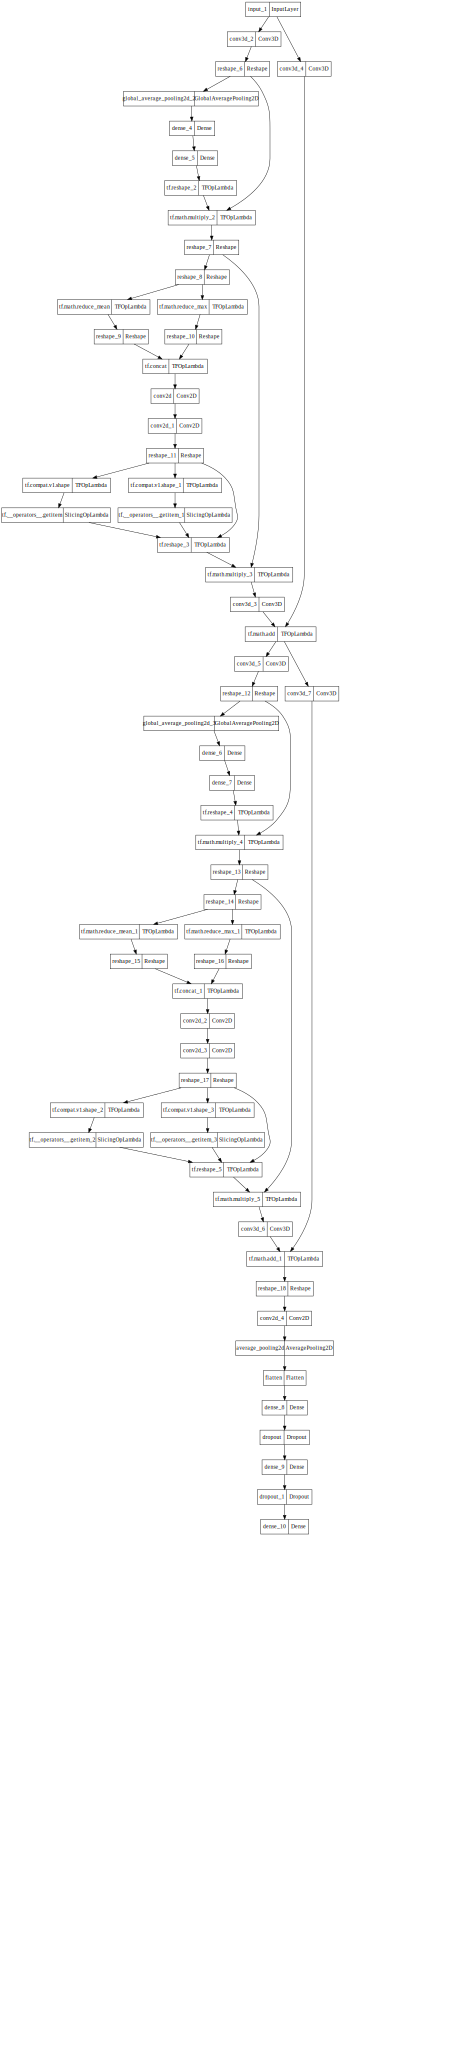

In [46]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [47]:
class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2.00, alpha=0.5,reduction=tf.keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        weight2 = y_pred * (1 - self.alpha)   + (1 - y_pred) * self.alpha
        fl2 = fl + epsilon * tf.math.pow(1-y_pred,self.gamma+1) * weight2
        reduced_fl2 = tf.reduce_max(fl2, axis=1)
        return tf.reduce_mean(reduced_fl2)

In [48]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss=FocalLoss(), optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [49]:
# checkpoint
filepath = "/content/drive/My Drive/Data3/DCT_HOG_Best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [50]:
import time
start=time.time() #Find Start Time
history = model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, callbacks=callbacks_list,validation_split=0.15)
end=time.time() #Find End time

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.0153 - accuracy: 0.2080
Epoch 1: accuracy improved from -inf to 0.20805, saving model to /content/drive/My Drive/Data3/DCT_HOG_Best-model.hdf5
14/14 [==============================] - 20s 380ms/step - loss: 1.0153 - accuracy: 0.2080 - val_loss: 0.7773 - val_accuracy: 0.3961
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.4494
Epoch 2: accuracy improved from 0.20805 to 0.44943, saving model to /content/drive/My Drive/Data3/DCT_HOG_Best-model.hdf5
14/14 [==============================] - 2s 126ms/step - loss: 0.6536 - accuracy: 0.4494 - val_loss: 0.5080 - val_accuracy: 0.5584
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.4506 - accuracy: 0.5770
Epoch 3: accuracy improved from 0.44943 to 0.57701, saving model to /content/drive/My Drive/Data3/DCT_HOG_Best-model.hdf5
14/14 [==============================] - 2s 132ms/step - loss: 0.4506 - accuracy: 0.5770 

In [51]:
# load best weights
model.load_weights("/content/drive/My Drive/Data3/DCT_HOG_Best-model.hdf5")
model.compile(loss=FocalLoss(), optimizer=adam, metrics=['accuracy'])

In [52]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, 30, 1)
Xtest.shape

(9225, 25, 25, 30, 1)

In [53]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(9225, 16)

In [54]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

289/289 [==============================] - 6s 17ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.95      0.96      0.96      1285
           2       0.97      0.96      0.96       747
           3       0.95      0.83      0.88       213
           4       1.00      1.00      1.00       435
           5       0.97      0.99      0.98       657
           6       1.00      1.00      1.00        25
           7       1.00      1.00      1.00       430
           8       0.00      0.00      0.00        18
           9       0.97      0.99      0.98       875
          10       0.98      0.98      0.98      2210
          11       0.98      0.97      0.98       534
          12       1.00      0.99      0.99       185
          13       0.99      1.00      1.00      1139
          14       0.98      0.98      0.98       347
          15       0.89      0.96      0.93        84

    accuracy            

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [55]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [56]:
def reports (X_test,y_test,name):
    start2 = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    end2 = time.time()
    print(end2 - start2)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [57]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/drive/Shareddrives/BTP_report/main-work/ip.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))
    x_file.write('\n')
    x_file.write('Time taken for training: {:.2f}s'.format(end-start))

289/289 [==============================] - 5s 17ms/step
7.017632007598877


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



289/289 [==============================] - 6s 19ms/step - loss: 0.0440 - accuracy: 0.9764


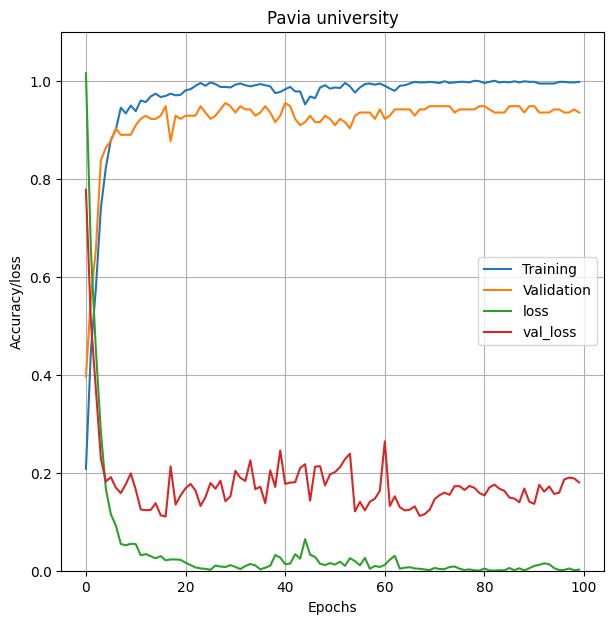

In [58]:

plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Accuracy/loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation','loss','val_loss'])
plt.title("Pavia university")
plt.savefig("/content/drive/Shareddrives/BTP_report/images/acc_curve_main_GPU-ip.png")
plt.show()

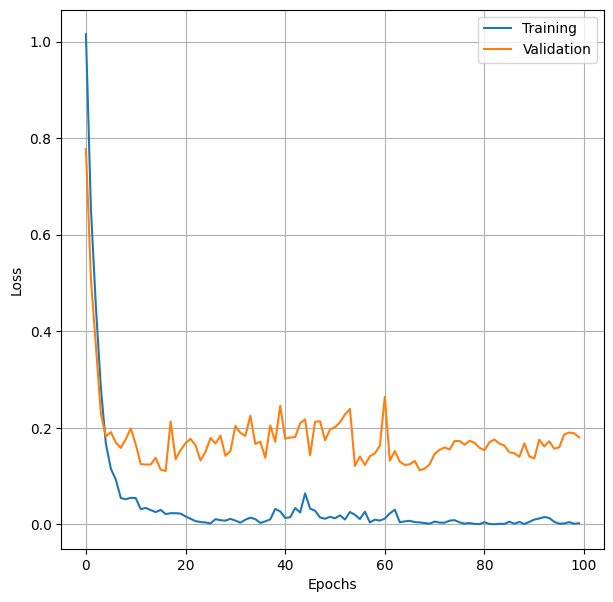

In [59]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
#plt.savefig("/content/drive/Shareddrives/BTP_report/images/loss_curve_main_GPU-ip.png")
plt.show()

In [60]:
#plt.plot(trained_model_[0].history['loss'][1:], label='Train loss', c='orange')
#plt.plot(trained_model_[0].history['val_loss'][0:], label='Validation loss', c='blue')
#plt.plot(trained_model_[0].history['loss'][2:], label='Validation loss', c='blue')
#plt.plot(trained_model_[0].history['val_loss'], label='Train loss', c='red')
#plt.axvline(x=213, c='gray', linestyle = '--')
#plt.title('Model loss for SalinasA')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend()
#plt.savefig('Validation loss except for SalinasA.png', dpi=100)
#plt.show()

In [61]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [62]:
# load the original image
X, y = loadData(dataset)
X.shape,y.shape

((145, 145, 200), (145, 145))

In [63]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = 15

In [64]:
X,pca = applyPCA(X, numComponents=numComponents)

In [65]:
#Binarization of image
X2=np.zeros(X.shape)
X2[:,:,:]=X[:,:,:]
bimage2 = (255*(X2 - np.min(X2))/np.ptp(X2)).astype(int)   
th2=np.sum(bimage2)//(145*145*15)
bimage2= np.where(bimage2 >= th2, 1, 0)

for i in range(15):
  Xtemp2 = bimage2[:,:,i]
  (hog_desc2, hog_image2) = feature.hog(Xtemp2, orientations=9, pixels_per_cell=(2, 2),
                                      cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys', visualize=True)
  hog_image_temp2=np.reshape(hog_image2, (145, 145, 1))
  X = np.concatenate((X, hog_image_temp2), axis=2)
  print(hog_image_temp2.shape,X.shape)

#import matplotlib.pyplot as plt
#_, axes = plt.subplots(2, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(10):
#  axes[i].imshow(bimage2[:,:,i])



(145, 145, 1) (145, 145, 16)
(145, 145, 1) (145, 145, 17)
(145, 145, 1) (145, 145, 18)
(145, 145, 1) (145, 145, 19)
(145, 145, 1) (145, 145, 20)
(145, 145, 1) (145, 145, 21)
(145, 145, 1) (145, 145, 22)
(145, 145, 1) (145, 145, 23)
(145, 145, 1) (145, 145, 24)
(145, 145, 1) (145, 145, 25)
(145, 145, 1) (145, 145, 26)
(145, 145, 1) (145, 145, 27)
(145, 145, 1) (145, 145, 28)
(145, 145, 1) (145, 145, 29)
(145, 145, 1) (145, 145, 30)


In [66]:
#import matplotlib.pyplot as plt
#_, axes = plt.subplots(4, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(20):
#    axes[i].imshow(X[:,:,i])

In [67]:
X.shape

(145, 145, 30)

In [68]:
#X[:,:,0:10]=dctn(X[:,:,0:10])

In [69]:
X = padWithZeros(X, PATCH_SIZE//2)
X.shape

(169, 169, 30)

In [70]:
#import matplotlib.pyplot as plt
#_, axes = plt.subplots(4, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(20):
#    axes[i].imshow(X[:,:,i])

In [71]:
# # calculate the predicted image
# outputs = np.zeros((height,width))
# for i in range(height):
#     for j in range(width):
#         target = int(y[i,j])
#         if target == 0 :
#             continue
#         else :
#             image_patch=Patch(X,i,j)
#             X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
#             X_test_image[0,:,:,:15,0]=dctn(X_test_image[0,:,:,:15,0])                                   
#             prediction = (model.predict(X_test_image))
#             prediction = np.argmax(prediction, axis=1)
#             outputs[i][j] = prediction+1

In [72]:
# ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [73]:
# predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [74]:
# spectral.save_rgb("/content/drive/My Drive/Data3/DCT_predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [75]:
# spectral.save_rgb(str(dataset)+"_ground_truth508_PU1.jpg", y, colors=spectral.spy_colors)

In [76]:
# print("Time taken for training: {:.2f}s".format(end-start)) #Calculate Time taken for training